In [205]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [206]:
# imports

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
import seaborn as sns
import plotly.graph_objects as go 


%matplotlib inline
# import geodataframe as gdf

import geopandas as gpd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')





# Project One

# What Attributes Determine a Yelp rating in the United States?

## 1. Introduction

This analysis contains data from the *Yelp Dataset* published by Yelp, and accessed through Kaggle. The Y variable studied is the Yelp rating restaurants receieve, in relation to five X variables analyzed in this report: 
the number of reviews a restaurant recieves, the city the resataurant is located, the number of checkins a restaurant has recorded, and the category value that a restaurant is associated with. 


The number of reviews a restaurant recieves is of interest because it could be the case that more popular restaurants recieve more reviews, but the ratings may reflect otherwise. Whether more reviews indicates higher-rated restaurants is of interest. The city a restaurant is located is examined to determine whether the geographical location of a restaurant is a determinate of the kind of rating a restaurant may recieve. The number of checkins a restaurant has recieved is studied to determine whether eagerness to report a checkin would correlate with higher ratings. The category items that a restaurant is associated with is analyzed to determine whether certain cuisines or keywords are predictive of the type of rating a restaurant may recieve.

This analysis specifically focuses on the data for restaurants in the US, and takes a deeper dive into the geographic setting 

## 2. Data Cleaning/Loading

In [207]:
# datasets
df_business = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business.csv'))
df_tip = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_tip.csv'))
df_attributes = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_attributes.csv'))
df_hours = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_hours.csv'))
df_checkin = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_checkin.csv'))
df_user = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_user.csv'))

### Data Cleaning for Users

In [208]:
df2_user = df_user.copy()
df2_user = df2_user.drop(columns=['friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos', 'compliment_hot'])
df2_user.head(10)

,user_id,name,review_count,yelping_since,average_stars
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,3.70
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,2.00
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,4.67
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,4.67
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,3.45
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,4.78
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,5.00
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,1.00
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,4.29
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,5.00


A clean copy of user data with columns removed because most users have no data recorded in those columns. The 'user_id' column contains the unique ID for each Yelp reviewer and contains the information of the other columns in the df2_users dataframe. The 'name' column contains the name the reviewer has indicated, the 'review_count' column indicates the total number of reviews the reviewer has written, the 'yelping_since' column indicates the date the Yelp user registered, and the 'average_stars' column indicates the average star rating the reviewer typically writes. 

### Data Cleaning for Businesses

In [277]:
df2_business = df_business.copy()
id_drops = []
for i in df2_business.index:
    if "Restaurants" not in df2_business['categories'][i] or df2_business['is_open'][i] != 1:
        id_drops.append(df2_business['business_id'][i])
    else:
        df2_business['categories'][i] = df_business['categories'][i].split(";")

df2_business = df2_business[df2_business.business_id.isin(id_drops) == False]

In [278]:
for i in df2_business['city'].index:
    df2_business['city'][i] = df2_business['city'][i].capitalize()
df2_business.head(10)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga falls,OH,44221,41.119535,-81.475690,3.5,116,1,"[American (New), Nightlife, Bars, Sandwiches, ..."
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,"[Italian, Restaurants]"
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Uptown,"""600 E 4th St""",Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,"[Restaurants, American (Traditional)]"
19,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""",NaN,"""9665 Bayview Avenue, Unit 1-4""",Richmond hill,ON,L4C 9V4,43.867565,-79.412662,3.5,34,1,"[French, Food, Bakeries, Restaurants]"
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""",Leslieville,"""1058 Gerrard Street E""",Toronto,ON,M4M 3A6,43.669256,-79.335902,3.5,39,1,"[Tiki Bars, Nightlife, Mexican, Restaurants, B..."
28,Dj0S-Oe4ytRJzMGUPgYUkw,"""Panera Bread""",NaN,"""38295 Chestnut Ridge Rd""",Elyria,OH,44035,41.343078,-82.067140,2.0,4,1,"[Soup, Salad, Sandwiches, Restaurants]"
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""",NaN,"""2777 Steeles Avenue W""",Toronto,ON,M3J 3K5,43.781816,-79.490433,5.0,3,1,"[Restaurants, Breakfast & Brunch]"
33,FXHfcFVEfI1vVngW2gVOpw,"""Bampot House of Tea & Board Games""",NaN,"""201 Harbord Street""",Toronto,ON,M5S 1H6,43.661582,-79.408878,4.0,55,1,"[Coffee & Tea, Restaurants, Food, Mediterranea..."
40,tRVx2c89coruPRwYhGTcTw,"""Yuzu""",NaN,"""13603 Madison Ave""",Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,"[Nightlife, Izakaya, Comfort Food, Cocktail Ba..."
45,rDMptJYWtnMhpQu_rRXHng,"""McDonald's""",NaN,"""719 E Thunderbird Rd""",Phoenix,AZ,85022,33.607070,-112.064382,1.0,10,1,"[Fast Food, Burgers, Restaurants]"


A clean copy of the business data which filters for businesses that are restaurants and capitalizes all the city names. The first column, 'business_id' contains the unique ID's for the restaurants on Yelp. The other columns in the df_business dataframe contain the specific details for each restaurant. The 'name' column specifies the name of the restaurant. The 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', and 'longitutde' columns all specify the location of the respective restaurants. The 'stars' column specifies the star rating the restaurants receive on Yelp, the 'review_count' column indicates the total amount of reviews the restaurants have recieved, and the 'categories' column contains the keywords these restaurants are labelled with. 

### Data Cleaning for Tips

In [211]:
df2_tip = df_tip.copy()
df2_business_tip = df2_business[['business_id', 'name', 'stars']]
df2_tip = df2_tip[df2_tip.business_id.isin(id_drops) == False]
df2_tip = pd.merge(df2_business_tip, df2_tip, on='business_id').drop(['business_id', 'likes'], axis = 1)

df2_tip.head(10)

,name,stars,text,date,user_id
0,"""Brick House Tavern + Tap""",3.5,People are giving this place 1 star because of...,2013-02-19,8v1rpTH0d8YjjGWA892l1Q
1,"""Brick House Tavern + Tap""",3.5,"Excellent selection of beers on tap, many scre...",2013-05-11,y_RCzjU-K_KrMBko3mMhsg
2,"""Brick House Tavern + Tap""",3.5,Great event held by yelp!! Will be back!!,2012-10-15,3OhkexT0E78zylIH426EOg
3,"""Brick House Tavern + Tap""",3.5,I love this place. They always take good care ...,2012-01-18,RgTByLRNRTJNmeWgp6Kg4Q
4,"""Brick House Tavern + Tap""",3.5,Chop Steak was surprisingly good. Love love lo...,2011-09-29,RgTByLRNRTJNmeWgp6Kg4Q
5,"""Brick House Tavern + Tap""",3.5,Good beer and even better food,2016-02-18,EAfLAFYv46w2SCvgN_m_VQ
6,"""Brick House Tavern + Tap""",3.5,Go!!,2014-08-06,yTIQesfMFpf038iEFx1keQ
7,"""Brick House Tavern + Tap""",3.5,"Try the Mac and Cheese, it's the best I have e...",2012-11-26,EaCzl3GqLvbq-IO3yOrm6g
8,"""Brick House Tavern + Tap""",3.5,So many beers on tap and huge snack menu. Week...,2017-09-29,4s_zxWFUqW6-TKYMPYUOiQ
9,"""Brick House Tavern + Tap""",3.5,"Beautiful women, great food and spirits.",2012-03-04,Er7va1rRXiQVVcz2LOwXKg


This dataframe illustrates a clean copy of the data in the 'yelp_tip' csv file where the business names are merged with the a user's review based on the 'business_id' of restaurants. The 'name' column specifies which restaurant has received the specific review. The 'stars' column indicates the number of stars that a user has given to a restaurant, the 'text' column contains the review comments that a user left, 'date' contains when a review was written and the 'user_id' column attaches the unique user's ID to the review they have written. 

### Data Cleaning for Attributes

In [212]:
df2_attributes = df_attributes.copy()
df2_business_attributes = df2_business[['business_id', 'name', 'stars']]
df2_attributes = df2_attributes[df2_attributes.business_id.isin(id_drops) == False]
df2_attributes = df2_attributes.drop(columns=['AcceptsInsurance', 'ByAppointmentOnly', 'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican', 'HairSpecializesIn_curly', 'HairSpecializesIn_perms', 'HairSpecializesIn_kids', 'HairSpecializesIn_extensions', 'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms', 'Music_dj', 'Music_karaoke', 'GoodForDancing', 'Smoking', 'DogsAllowed', 'BusinessAcceptsBitcoin', 'AgesAllowed' ])
df2_attributes = pd.merge(df2_business_attributes, df2_attributes, on='business_id').drop(['business_id'], axis = 1)
df2_attributes.head(10)

,name,stars,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,RestaurantsPriceRange2,GoodForKids,...,BYOB,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,RestaurantsCounterService
0,"""Brick House Tavern + Tap""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,"""Messina""",4.0,Na,Na,False,False,False,False,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,"""Showmars Government Center""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,"""Maxim Bakery & Restaurant""",3.5,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,"""Chula Taberna Mexicana""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
5,"""Panera Bread""",2.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
6,"""Sunnyside Grill""",5.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
7,"""Bampot House of Tea & Board Games""",4.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
8,"""Yuzu""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
9,"""McDonald's""",1.0,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


This dataframe reflects a clean copy of data from the 'yelp_attributes' csv file by removing attributes that are unrelated to restaurants, and only contains restaurant businesses. Additionally, the restaurant name and star rating from the 'yelp_businesses' dataframe is merged with the 'yelp_attributes' data based on the unique 'business_id' that is associated with each business. The 'name' column indcates the name of the restaurants, and 'stars' contains the number of Yelp stars that a restaurant has recieved. The columns 'BusinessAcceptsCreditCards', 'BusinessParking_garage', 'BusinessParking_street', 'BusinessParking_validated', 'BusinessParking_lot', 'BusinessParking_valet', and 'GoodForKids' provide information on the payment method available, the convenience of parking, and whether the environment is suitable for children. The columns 'BYOB', 'Corkage', 'DietaryRestrictions_dairy-free', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_vegan','DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_soy-free', 'DietaryRestrictions_vegetarian', and 'RestaurantsCounterService' contain information pertaining to the dietary accessibility of a restaurant.  

### Data Cleaning for Business Hours

In [213]:
df2_hours = df_hours.copy()
df2_business_hours = df2_business[['business_id', 'name', 'stars']]
df2_hours = df2_hours[df2_hours.business_id.isin(id_drops) == False]

# clean restaurants with no business hours any day
no_hours = []
for i in df2_hours.index:
    if df2_hours['monday'][i] == df2_hours['tuesday'][i] == df2_hours['wednesday'][i] == df2_hours['thursday'][i] == df2_hours['friday'][i] == df2_hours['saturday'][i] == df2_hours['sunday'][i] == 'None':
        no_hours.append(i)

df2_hours.drop(no_hours, axis=0, inplace=True)

#clean data for opening and closing hours 
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

for col in days:
    df2_hours[[col+'_open', col+'_close']] = df2_hours[col].apply(lambda x: pd.Series(str(x).split('-')))

df2_hours = df2_hours.drop(days, axis=1)
df2_hours = pd.merge(df2_business_hours, df2_hours, on='business_id').drop(['business_id'], axis = 1)
df2_hours.head(10)


,name,stars,monday_open,monday_close,tuesday_open,tuesday_close,wednesday_open,wednesday_close,thursday_open,thursday_close,friday_open,friday_close,saturday_open,saturday_close,sunday_open,sunday_close
0,"""Brick House Tavern + Tap""",3.5,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,2:0,11:0,0:0
1,"""Messina""",4.0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,None,NaN
2,"""Showmars Government Center""",3.5,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,None,NaN,None,NaN
3,"""Maxim Bakery & Restaurant""",3.5,11:30,22:0,11:30,22:0,11:30,22:0,11:30,22:0,11:30,23:0,11:0,23:0,11:0,22:0
4,"""Chula Taberna Mexicana""",3.5,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,10:30,2:0,10:30,2:0
5,"""Panera Bread""",2.0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,22:0,7:0,22:0,7:0,20:0
6,"""Sunnyside Grill""",5.0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0
7,"""Bampot House of Tea & Board Games""",4.0,17:0,23:0,11:0,23:0,11:0,23:0,11:0,23:0,12:0,1:30,12:0,1:30,12:0,23:0
8,"""Yuzu""",3.5,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,11:0,2:0,None,NaN
9,"""Charr An American Burger Bar""",3.0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,23:0,11:0,23:0,11:0,21:0


This dataframe includes a clean copy of the business hours data where the restaurant opening and closing times for each day are sperated into individual columns. Restaurant names and their rating are matched with their business hours based on their 'business_id'. The 'name' column includes the names of the restaurants, and the 'stars' column specifies the rating the restaurant has recieved on Yelp. The columns 'monday_open', 'tuesday_open', 'wednesday_open', 'thursday_open', 'friday_open', 'saturday_open', and 'sunday_open' indicate the time that the restaurants open on each day of the week. The columns 'monday_close', 'tuesday_close', 'wednesday_close', 'thursday_close',  'friday_close', 'saturday_close', and 'sunday_close' contain the time that the restaurants close on each day of the week. 

### Data Cleaning for Yelp Checkins

In [214]:
df2_checkin = df_checkin.copy()
df2_checkin = df2_checkin[df2_checkin.business_id.isin(id_drops) == False].drop(columns = ['weekday', 'hour']).groupby('business_id')['checkins'].sum()

df2_business_checkin = df2_business[['business_id', 'name', 'stars']]

df2_checkin = pd.merge(df2_checkin, df2_business_checkin, on='business_id')
df2_checkin = df2_checkin.drop(['business_id'], axis = 1)[['name', 'checkins', 'stars']]

df2_checkin.head(10)

,name,checkins,stars
0,"""John's Chinese BBQ Restaurant""",139,3.0
1,"""Delmonico Steakhouse""",2568,4.0
2,"""Sunnyside Grill""",89,3.5
3,"""The Bar At Bermuda & St. Rose""",490,3.5
4,"""Mm Mm Pizza""",20,4.0
5,"""Happy Moose Bar and Grill""",89,3.5
6,"""Hungry Howie's Pizza""",93,3.0
7,"""Denny's""",60,2.0
8,"""Keung Kee Restaurant""",148,3.5
9,"""Pio Pio""",672,4.0


This dataframe contains a clean copy of data from the 'yelp_checkins' csv file, and analyzes restaurants by their total number of checkins and the star rating they have recieved. The 'name' column includes the name of the restaurant, the 'checkins' column indicates the total number of checkins a restaurant has received on Yelp, and the 'stars' column contains the star rating a restaurant has received. 

### Data Cleaning for Real Personal Income in US States in 2021

In [215]:
# importing data for personal income
income_data = pd.read_excel('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/PI_2021.xlsx')
# changing column names
income_data = income_data.rename(columns={'Unnamed: 1': 'Name', 'Unnamed: 2': 'Personal Income'}).drop(columns=['SARPI Real personal income and real personal Consumption Expenditures (PCE) by state'], axis=1)
# data cleaning for state data for states included in the Yelp Dataset
state_names = ['Arizona', 'Illinois', 'North Carolina', 'Nevada', 'Ohio', 'Pennsylvania', 'South Carolina', 'Wisconsin']
income_data = income_data[income_data.Name.isin(state_names)]

income_data

,Name,Personal Income
8,Arizona,362113.5
19,Illinois,728882.6
34,Nevada,171884.2
39,North Carolina,548116.5
41,Ohio,628659.7
44,Pennsylvania,750118.9
46,South Carolina,252155.0
55,Wisconsin,326703.2


This data cleaning involves importing a dataset describing the real the personal income of citizens in United States. The column 'Name' includes the names of states and the 'Personal Income' column indicates the real personal income in the respective state in millions of dollars with 2012 as the base year.

## 3. Summary Statistic Tables

In [216]:
def get_summary_statistic(df, column):
    result = {column: [], 'total_restaurants': [], 'sum_stars' : [], 'average_stars': []}
    # access the cells
    for i in df.index:
        # check for list condition
        if type(df[column][i]) == list:
            for j in df[column][i]:
                if j not in result[column]:
                    result[column].append(j)
                    result['total_restaurants'].append(1)
                    result['sum_stars'].append(df['stars'][i])
                else:
                    index = result[column].index(j)
                    result['total_restaurants'][index] += 1
                    result['sum_stars'][index] += df["stars"][i]
        else:
            if df[column][i] not in result[column]:
                result[column].append(df[column][i])
                result['total_restaurants'].append(1)
                result['sum_stars'].append(df["stars"][i])
            else:
                index = result[column].index(df[column][i])
                result['total_restaurants'][index] += 1
                result['sum_stars'][index] += df["stars"][i]

    for i in result[column]:
        avg = result['sum_stars'][result[column].index(i)]/result['total_restaurants'][result[column].index(i)]
        result['average_stars'].append(round(avg, 2))

    dataframe = pd.DataFrame(result).sort_values(by='total_restaurants', ascending=False)
    return dataframe

The function above produces a summary statistics data frame which passes in a data frame and a column name to be analyzed. The 'X' variable consists of items in the given column and the 'Y' variable is the average star rating for restaurants that fall under a category in the column. The summary statistic provides the "total_restaurants", which reflects how many restaurants fall under a category item, "sum stars", which reflects the total sum of stars restaurants in the category receive, and "average_stars", which reflects the average star rating a restaurant in that category receives. 

### Summary statistics of reviews and Yelp stars

In [217]:
review_summary_statistic = get_summary_statistic(df2_business.copy(), 'review_count').drop(columns=['sum_stars']).sort_values(by='review_count')

review_summary_statistic

,review_count,total_restaurants,average_stars
6,3,3217,3.31
5,4,2125,3.37
1,5,1764,3.34
13,6,1557,3.31
2,7,1380,3.34
...,...,...,...
427,4774,1,4.00
903,4869,1,4.50
699,5950,1,3.50
850,7009,1,4.00


This summary statistic indicates the average star rating for restaurants with a certain number of reviews. The 'review_count' column indicates the number of reviews that restaurants receive and the 'average_stars' column indicates the average star rating that restaurants with that specific number of reviews receive. The summary statistic is ordered by the 'review_count' column going from least to most Yelp restaurant reviews. From this data, it can be observed that more restaurants tend to have lower restaurant review counts compared to higher restaurant review counts. Additionally, the average star rating for restaurants with less reviews tend to have lower average Yelp star ratings which may lead to inferences about the effect of the popularity and reputation of restaurants on higher Yelp ratings. 

### Summary statistics of Category types and Yelp stars

In [218]:
category_summary_statistic = get_summary_statistic(df2_business.copy(), 'categories').drop(columns=['sum_stars', 'total_restaurants']).drop(6).drop(11).head(15)
category_summary_statistic.sort_values(by='average_stars')

,categories,average_stars
26,Fast Food,2.85
5,Burgers,3.00
36,Pizza,3.35
31,Chinese,3.35
4,American (Traditional),3.36
12,Mexican,3.44
3,Sandwiches,3.46
7,Italian,3.54
1,Nightlife,3.55
2,Bars,3.55


This summary statistic reflects a category restaurants indicate in their Yelp descriptions and the average star rating for restaurants that fall under the respective category. The 'categories' column indicates the specified category, and the 'average_stars' column indicates the average number of stars restaurants in that category receive. This summary is ordered by the lowest to highest rated categories restaurants are tagged with, on average. From the data, restaurants tagged with the Fast Food category and food items associated with it such as Burgers and Pizza tend to receive lower Yelp ratings. On the other hand, more dine-in restaurant environments such as Cafes, Breakfast & Brunch, and Bard tend to recieve higher Yelp ratings. These findings may suggest a difference in quality, service, and overall experience in more formal restaurant establishments as opposed to their informal counterparts establishments. Furthermore, there may be a significance in the demographic and expectation these different restaurant types are catering to. More informal restuarants may not have the pressure or need to create an elaborate experience for customers because it is seen as an inferior good, and customers may have built-in expectations that are low. On the other hand, more formal restuarnats may have an added pressure to set themselves apart as more normal good, as well as the importance for establishing a strong reputation. 

### Summary Statistics of the Correlation Between the City a Restaurant is located and its Yelp Rating

In [219]:
city_summary_statistic = get_summary_statistic(df2_business.copy(), 'city').drop(columns=['sum_stars']).drop(columns=['total_restaurants'])
interested = ['Toronto', 'Las vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Montreal', 'Edinburgh', 'Stuttgart']
city_summary_statistic = city_summary_statistic[city_summary_statistic.city.isin(interested) == True]
city_summary_statistic.sort_values(by='average_stars')

,city,average_stars
2,Charlotte,3.39
7,Phoenix,3.42
4,Toronto,3.44
9,Las vegas,3.44
10,Montreal,3.57
16,Scottsdale,3.66
1,Stuttgart,3.74
12,Edinburgh,3.83


This summary statistic describes the average star rating for restaurants in their respective cities. The 'city' column lists the top 8 cities where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these cities receive. The data is formatted in ascending order for the average Yelp rating in the specified cities, which were selected for having the most restaurant data recorded in the Yelp Dataset. From this summary, cities located in North America such as Charlotte and Phoenix received lower Yelp ratings, on average, in comparison to cities located in Europe such as Stuggart and Edinburgh. This data suggest that there may exist a difference in the quality of restaurants and/or the types of reviewers and their expectations between North American and European restaurants. 

### Summary Statistic of Correlation Between the State a Restaurant is Located and its Yelp Rating

In [220]:
top_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'BW':[], 'EDH':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in top_state_summary_statistic['state'].index:
    if top_state_summary_statistic['state'][i] in new_frame:
        new_frame[top_state_summary_statistic['state'][i]] = top_state_summary_statistic['average_stars'][i]
top_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
top_state_summary_statistic.columns = ['state', 'average_stars']
top_state_summary_statistic.sort_values(by='average_stars')

,state,average_stars
3,IL,3.34
4,NC,3.38
7,ON,3.40
0,AZ,3.41
5,NV,3.43
6,OH,3.43
10,WI,3.47
8,PA,3.50
9,QC,3.68
1,BW,3.74


This summary statistic describes the average star rating for restaurants in their respective states for the top 10 states with the most restaurants reported in the dataset. The 'state' column lists the states where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these states receive. This summary is formatted in ascending order of the average Yelp rating for restaurants in their respective state. It is observed that on average, North American restaurants in states such as Illinois (IL) and North Carolina (NC) tend to receive lower Yelp ratings in comparison to European states such as Baden-Württemberg (BW) and Edinburgh (EDH). This suggests that there may be a difference in restaurant quality or reviewers and their expectations in North America and Europe. 

### Summary Statistic of Correlation Between Checkins and Yelp Stars

In [221]:
checkin_summary = get_summary_statistic(df2_checkin, "checkins").drop(columns=['sum_stars', 'total_restaurants'])
checkin_summary.sort_values(by='checkins')


,checkins,average_stars
87,1,3.45
18,2,3.44
9,3,3.43
23,4,3.42
39,5,3.38
...,...,...
1350,20990,3.50
1124,25158,4.50
1537,26378,4.00
1168,28272,3.00


This summary of statistics reflects the total number of check-ins restaurants have received and the average Yelp star rating they typically receive. The 'checkins' column represents the number of check-ins that restaurants have received and the 'average_stars' column represents the average star rating restaurants with that number of check-ins typically receive. The data is formatted in ascending order for number of checkins restaurants recieve on Yelp. From this data it is observed that restaurants with less checkins tend to receive lower ratings, on average, in comparison to restaurants which recieve more checkins. for example, restaurants with only 1 checking receive a 3.45 Yelp rating in comparison to restaurants with 32393 checkins which recieve 4.50 stars, on average. This may suggest that restaurants that are more highly rated tend to receive more checkins due to a popularity factor, or some quality which makes customers of these restaurants to be more inclined to use the checkin feature, as opposed to restaurants with lower ratings. 

### Summary Statistic of Correlation between a US state and the Number of Restaurants and the Average Rating for Those Restaurants

In [268]:
# Getting the state and star ratings
us_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}

for i in us_state_summary_statistic['state'].index:
    if us_state_summary_statistic['state'][i] in new_frame:
        new_frame[us_state_summary_statistic['state'][i]] = us_state_summary_statistic['average_stars'][i]
us_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
us_state_summary_statistic.columns = ['state', 'average_stars']

# combining 
us_num_summary_statistic = get_summary_statistic(df2_business, 'state')
total = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}
reviews = {'AZ':[0], 'PA':[0], 'SC':[0], 'IL':[0], 'NC':[0], 'NV':[0], 'OH':[0], 'PA':[0], 'WI':[0]}

us_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}

for i in us_num_summary_statistic['state'].index:
    if us_num_summary_statistic['state'][i] in total:
        total[us_num_summary_statistic['state'][i]] = us_num_summary_statistic['total_restaurants'][i]
us_num_summary_statistic =  pd.DataFrame(list(total.items()))
us_num_summary_statistic.columns = ['state', 'total_restaurants']

for i in df2_business['state'].index:
    if df2_business['state'][i] in reviews:
        reviews[df2_business['state'][i]] += df2_business['review_count'][i].astype(int)

state_reviews =  pd.DataFrame(list(reviews.items()))
state_reviews.columns = ['state', 'review_total']

for i in state_reviews.index:
    state_reviews['review_total'][i] = state_reviews['review_total'][i][0]

us_states_1 = pd.merge(us_num_summary_statistic, us_state_summary_statistic, on ='state')
us_states = pd.merge(us_states_1, state_reviews, on ='state')
us_states = us_states.drop(columns=['total_restaurants_y', 'sum_stars'], axis=1)
us_states.rename(columns = {'total_restaurants_x':'total_restaurants'}, inplace = True)
us_states.sort_values(by='average_stars')

,state,total_restaurants,average_stars,review_total
2,SC,140,3.24,5495
3,IL,453,3.34,20491
4,NC,2924,3.38,177494
0,AZ,7367,3.41,788960
5,NV,4851,3.43,892223
6,OH,3762,3.43,149629
7,WI,1110,3.47,64367
1,PA,2759,3.50,138271


This summary statistic creates a holistic representation of the Yelp restaurant data and how it relates to the state location for restaurants in the US which were included in the Yelp Dataset. The 'state' column indicates the specific US state, 'total_restaurants' reflects the total amount of restaurants recorded for each state, 'average_stars'. This summary statistic is formatted in ascending order for the average Yelp rating of restaurants in their respective state. It is observed that on average, restaurants in states such as South Carolina (SC) and Illinois (IL) tend to receive lower ratings whereas restaurants in states such as Pennsylvania (PA) and Wisconsin (WI) tend to receive higher ratings. There seems to be some normally distributed correlation between the number of restaurants in each state and the total number of reviews written in each state on the average rating of restaurants. 

## 4. Plots, Histograms, Figures

### Line Plot for Number of Reviews and Average Restaurant Rating

Text(0, 0.5, 'Rating')

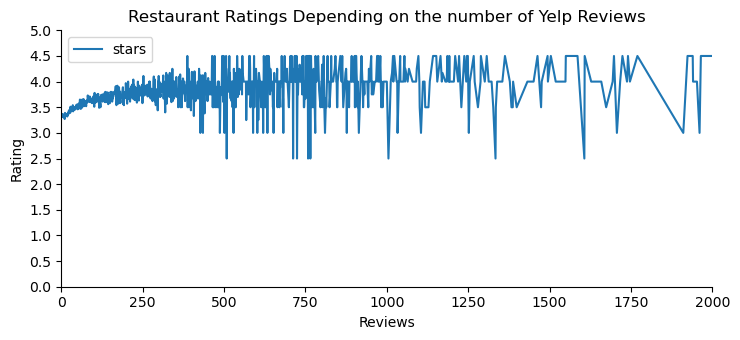

In [223]:
review = []
stars = []
for i in review_summary_statistic.index:
    review.append(review_summary_statistic['review_count'][i])
    stars.append(review_summary_statistic['average_stars'][i])
df = pd.DataFrame({
   'review':review,
   'stars': stars})
lines = df.plot.line(x ='review', y='stars')
lines.set_xlim(0, 2000)
lines.set_ylim(0, 5)
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
lines.spines['right'].set_visible(False)
lines.spines['top'].set_visible(False)
lines.set_title("Restaurant Ratings Depending on the number of Yelp Reviews")
lines.set_xlabel('Reviews')
lines.set_ylabel('Rating')

This line graph illustrates the number of reviews restaurants recieve and the average rating that restaurants with the specified reviews recieve. From this graph, it can be observed that when restaurnats have less reviews of around under 250, they tend to recieve ratings of about 3.5 Yelp stars, on average. However, when restaurants have more ratings, the average rating can vary a lot more, and where the range encompasses ratings around 2.5 to 4.5. Observations can be drawn from this data that when more reviews are given, the true quality of the restauarant may be more likely to be reflected. 

### Bar Chart for Restaurant Categories and the Average Restaurant Rating

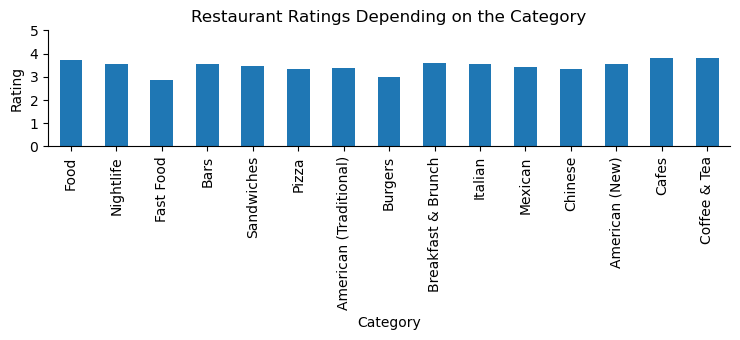

In [224]:
categories = []
stars = []
for i in category_summary_statistic.index:
    categories.append(category_summary_statistic['categories'][i])
    stars.append(category_summary_statistic['average_stars'][i])
df = pd.DataFrame({'category': categories, 'stars': stars})

ax = df.plot.bar(x='category', y='stars', legend=False)
ax.set_xlabel('Category')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the Category")
plt.yticks([0, 1, 2, 3, 4, 5])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This box plot illustrates the top 15 categories that restaurants are tagged with and the average rating that restaurants in those categories receive. This is an correlation to observe because it can predict the average rating a restaurant may recieve if they fall under this category, or if they add this category to their restaurant description. Additionally, it can reflect the quality of the restaurants under these categories. For example, restaurants that fall under the 'Fast Food' and 'Burger'category on average recieve less ratings than the other most common retaurant categories which could lead to a potential analysis of whether fast food restuarant quality is on average worse than restaurants in the other categories. 

### Scatterplot for the  Rating Restaurants Recieve Depending on the Number of Checkins

Text(0.5, 1.0, 'Restaurant Ratings Depending on Checkins')

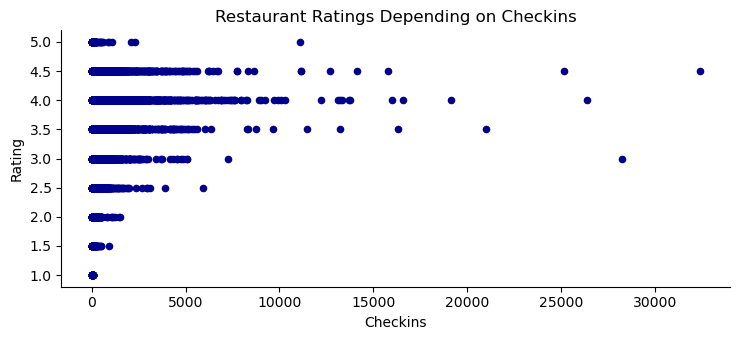

In [225]:
ax = df2_checkin.plot.scatter(x='checkins', y='stars', c='DarkBlue')

ax.set_xlabel('Checkins')
ax.set_ylabel('Rating')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Restaurant Ratings Depending on Checkins")

This scatterplot illustrates the spread of how the number of check-ins restaurants receive correlates with ratings. From this plot, it can be observed that it is more densely packed around a rating of 4 which suggests that people are more likely to check in on Yelp for restaurants when it is considered a 4-star restaurant. These results also reflect how Yelper's may be more likely to interact with a restaurant when they consider it to be around a 4-star rating.

### Boxplot for Average Restaurant Rating Based on the City

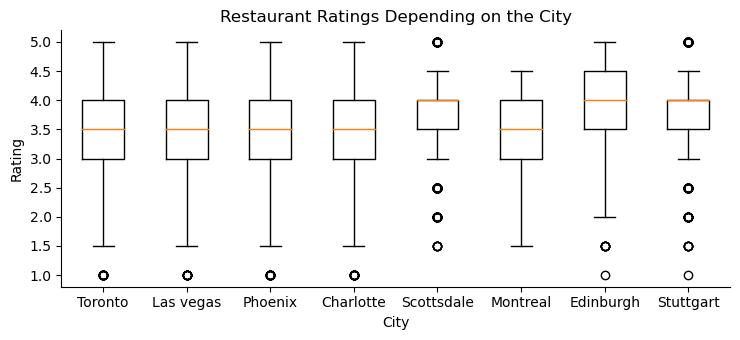

In [226]:
new_frame = {'Toronto':[], 'Las vegas':[], 'Phoenix':[], 'Charlotte':[], 'Scottsdale':[], 'Montreal':[], 'Edinburgh':[], 'Stuttgart':[]}
df2_city = df2_business[['city','stars']]

for i in df2_city.index:
    if df2_city['city'][i] in new_frame:
        new_frame[df2_city['city'][i]].append(df2_city['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('City')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the City")
plt.show()

This boxplot represents the average rating of restaurants based on the city they are located in. Results from this plot can lead to further conclusions of restaurant quality depending on the city, or possibly how Yelpers review restaurants in those cities. For restaurants, this data could be important so that they can expect, on average, the kind of review they may receive. For Yelpers, this data could be important for knowing the quality of restaurants they can expect when in a city. The boxplot's findings show how cities in North America tend to receive Yelp ratings of around 3.5 stars, while cities in Europe tend to receive higher Yelp ratings of around 4.0 stars. These results may lead to further elaboration on whether Yelpers in North America and Europe rate restaurants differently, or whether restaurant quality is on average better in Europe. 

### Boxplot for Average Restaurant Rating Based on the State

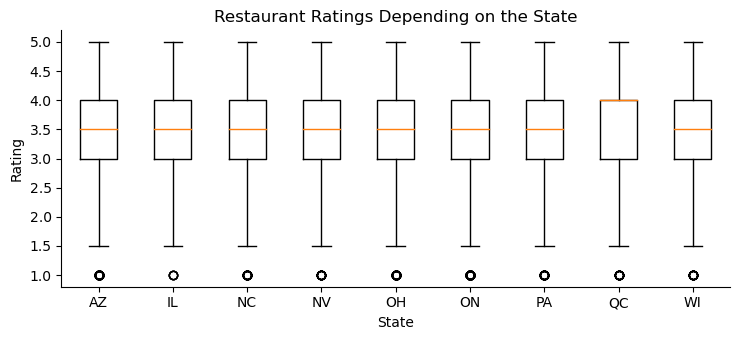

In [227]:
df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in df2_state.index:
    if df2_state['state'][i] in new_frame:
        new_frame[df2_state['state'][i]].append(df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State")
plt.show()


This boxplot illustrates the average restaurant ratings of restaurants based on the state they are in. This information could be useful for restaurants to see whether the state location of their restaurant is a factor in the type of rating that they would expect to receive. These states are displayed to represent the top 9 states reported with the highest number of restaurants reported. From this graph, it can be observed that QC is reported to have the highest restaurant ratings, on average. The other states all tend to have average restaurant ratings of around 3.5 stars. Interstingly, QC is the only non-American state, and this observation could lead to two possible conclusions. Yelpers in the United States may on average review restaurants lower than Yelpers in Canada, or the quality of restaurants in Canada may on average be better. The circles on the graph represent outlier restaurants in their respective states.

### Boxplot for Average Restaurant Rating Based on the State Located in the United States

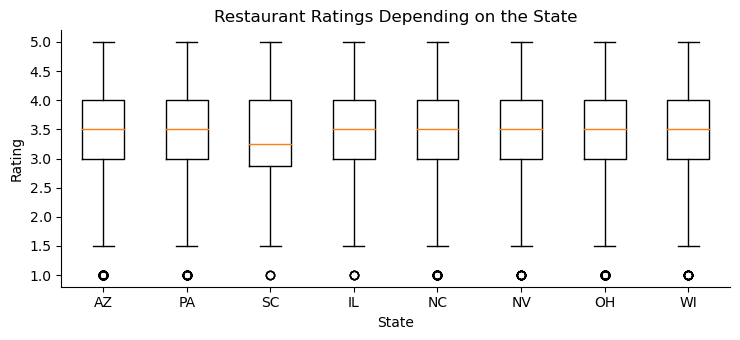

In [228]:
us_df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'WI':[]}
for i in df2_state.index:
    if df2_state['state'][i] in new_frame:
        new_frame[df2_state['state'][i]].append(df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State")
plt.show()

This boxplot illustrates the average restaurant ratings of restaurants based on the US state they are in. The states represented are 8 US states reported in the Yelp Dataset From this graph, it is observed that all the restaurants in the states represented except for South Carolina (SC) receive similar Yelp ratings, on average. The range of quartiles of the boxplots are also similar with South Carolina (SC) having a slightly larger range which may suggest that the types of restaurnats in South Carolina may vary in some influencial way in comparison to the other states reported. 

# 2. Project Two

## 2.1 The Message


The main concern of this project is to determine the attributes which determine Yelp review ratings for restuarants located in the United States by analyzing on the state level for the correlation between the number of restaurants and reviews on the Yelp rating that restaurants recieve. This question can lead to futher inquires of whether Yelp reviewers in different States rate restaurants on different scales, or if restaurants in different states serve at varying quality levels as well as the effect of competition of restaurants on the rating. Furthermore, this analysis analyzes the effect of competition between restaurants on their rating and quality.

A visualization to explore this question involves a scatter plot of the US states included in the Yelp Dataset to . The number of restaurants in a state is plotted on the x-axis, the average Yelp rating restaurants in the respective state is plotted on the y-axis, and the total number of reviews written for restaurants in that state is represented in a colorbar gradient from light to dark blue.

In the scatterplot below, it is observed that on average, restaurants across the US states tend to receive ratings between 3 and 4 Yelp stars. There exists a positive correlation between the number of restaurants in each state and the number of reviews which reflect that more restaurants will result in more reviews. There is a weak correlation between the average restaurant rating by state and the number of restaurants present, but analysis at a smaller scale may result in stronger results.

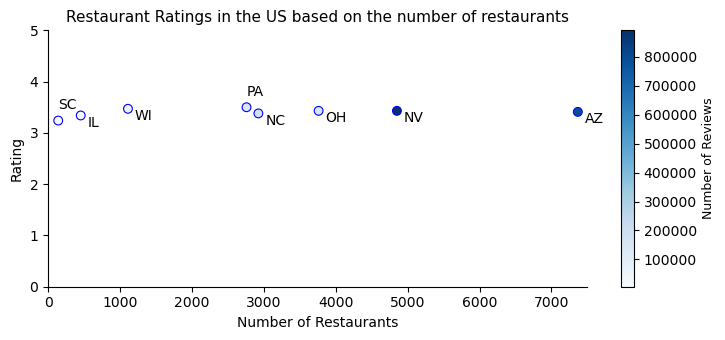

In [332]:
plt.scatter(us_states.total_restaurants, us_states.average_stars, s=40, c=us_states.review_total, cmap='Blues', edgecolors='blue', linewidth=0.8)

for (i, row) in us_states.iterrows():
    state = row.state
    if state in ['SC', 'PA']:
        offset = (0, 8)
    else:
        offset = (5,-8)
    plt.annotate(
        state, xy=(row["total_restaurants"], row["average_stars"]), xytext=offset, textcoords='offset points', fontsize=10
    )

plt.xlim([0, 7500])
plt.ylim([0, 5])
plt.xlabel('Number of Restaurants')
plt.ylabel('Rating')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Restaurant Ratings in the US based on the number of restaurants').set_size(11)
plt.colorbar().set_label(label='Number of Reviews',size=9)

plt.show()

## 2.2 Maps and Interpretations

### Map of Restaurants and Their Yelp Ratings in the United States

Text(0.5, 1.0, 'Restaurants in the United States')

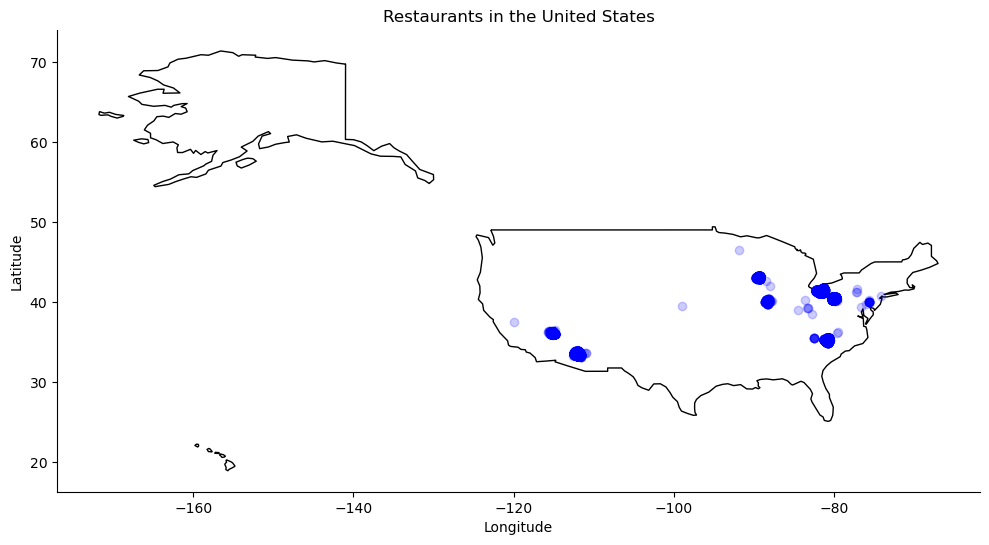

In [240]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

# plotting a worldmap
fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white', markersize=5)

# restaurants 
df = df2_business[df2_business.state.isin(us_states)]
df["coordinates"] = list(zip(df.longitude, df.latitude))
df["coordinates"] = df["coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="coordinates")

gdf.plot(ax=gax, color='blue', alpha = 0.2)

# labeling the map
gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
gax.set_title('Restaurants in the United States')

In this map, all the restaurants included in the Yelp Dataset located in the United States are plotted as blue points. The darker blue regions on the map indicate areas where more restaurants are located, and the lighter blue regions on the map indicate areas with less restaurants. From this map it can be observed that there is distinct clustering of restaurants in certain regions which may suggest that restaurants tend to be establish around each other. This phenomena may be due to the business mindset of restaurants for opening in more densly populated city centers.  

### Density Heatmap of Restaurants and their Ratings in Arizona

In [276]:
# get the state of Arizona
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")

df = df2_business.copy()
# Arizona restaurant coordinates
df["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))

df["coordinates_point"] = df["coordinates"].apply(Point)

df_states = df.groupby('state')

# apply the selector to subset

df_arizona = df_states.get_group('AZ')
plot = px.density_mapbox(df_arizona, lat='latitude', lon='longitude', z='stars', opacity=0.5, radius=5, title="Heatmap of Restaurant Ratings in Arizona", mapbox_style="open-street-map")
plot

## make 2 comparing east & west cost

This density heatmap of Arizona illustrates the concentration of restaurants in Arizona, against the Yelp star rating that the restaurants recieve. From this graph, dense clusters of restaurants are observed around major cities such as Surprise, Glendale, Phoenix, Scottsdale, Chandler and Mecca. Restaurants in those cities tend to receive higher ratings compared to restaurants further from the major cities in Arizona. This data is reflected by the brightly colored yellow center of the map, indicating higher-rated restaurants, and the purple outline indicating lower-rated restaurants. From this map, the conclusion that areas with a greater density of restaurants tend to have more highly rated restaurants which could be due to the effects of competition, or the types of Yelp reviewers in those areas. 

### Map of the US and average Yelp ratings by state

<AxesSubplot:title={'center':'Average Restaurant Yelp Rating by State'}>

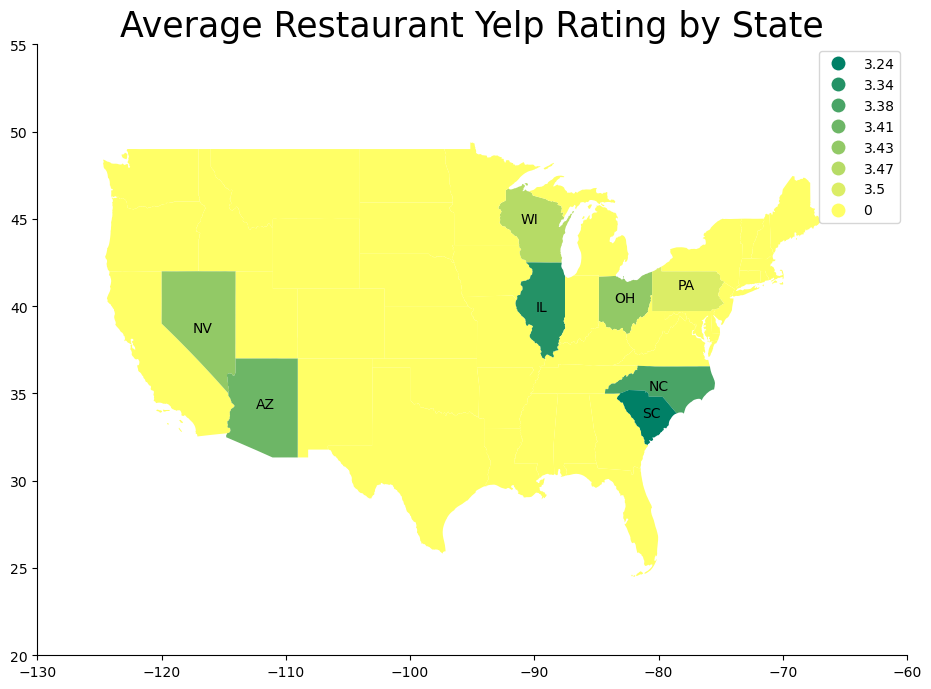

In [327]:
 # url of our shape file 
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
df_state_data = us_states_1[['state','average_stars']]
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS'})

# merging the data together
geo_merge=geo_usa.merge(df_state_data,how='left', left_on='STUSPS', right_on='state')
geo_merge.fillna('0', inplace=True)

# plot USA map 
ax = geo_merge.plot(column='average_stars',figsize=(25, 7),cmap='summer', legend=True)

geo_merge['coords'] = geo_merge['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge['coords'] = [coords[0] for coords in geo_merge['coords']]

# labelling the states 
for idx, row in geo_merge.iterrows():
    state_text = geo_merge['STUSPS'][idx]
    if state_text in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
        plt.annotate(text=state_text, xy=row['coords'],
                    horizontalalignment='center', fontsize=10)

plt.xlim(-130,-60)
plt.ylim(20,55)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Average Restaurant Yelp Rating by State',fontsize=25)
ax



This map generates a visual for the average Yelp star rating for restaurants in the states with data provided. The average rating is represented by a gradient from the color yellow to green with yellow indicating that the states did not have data provided in the Yelp Dataset, and the darkness of the gradient towards green indicating a Yelp rating closer to 5. It is apparent that restaurants in the states of Illinois, South Carolina, and North Carolina tend to receive the highest Yelp ratings, on average, while restaurants in Pennsylvania tend to receive the least ratings, on average. 

### Map of the US and the Number of restaurants in each State

<AxesSubplot:title={'center':'Number of Retaurants by State'}>

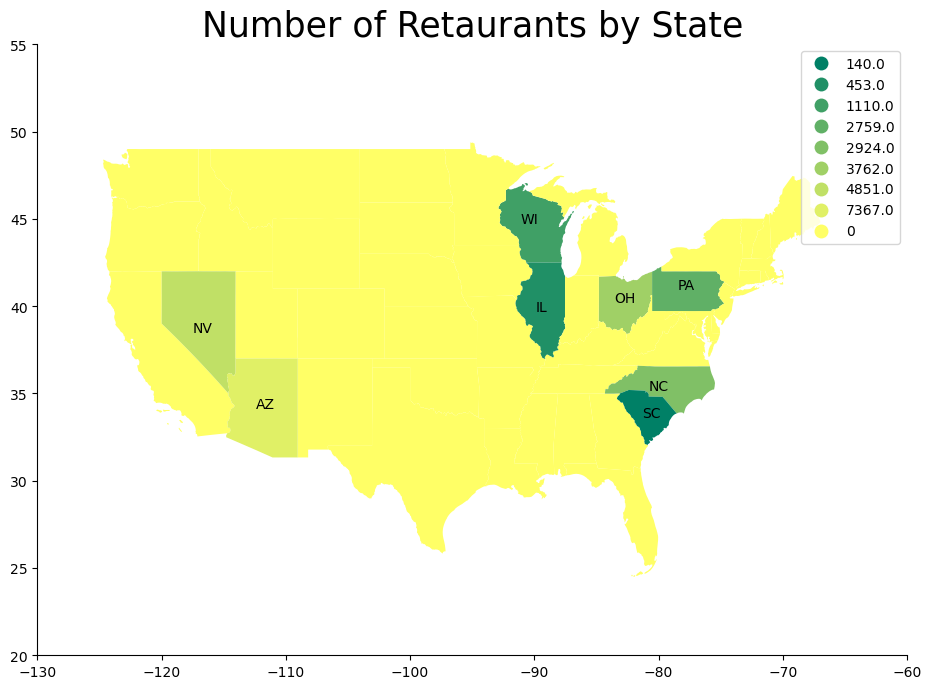

In [328]:
 # url of our shape file 
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
df_state_data = us_states[['state','total_restaurants']]
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS'})

# merging the data together
geo_merge_1=geo_usa.merge(df_state_data,how='left', left_on='STUSPS', right_on='state')
geo_merge_1.fillna('0', inplace=True)

# plot USA map 
ax = geo_merge_1.plot(column='total_restaurants',figsize=(25, 7),cmap='summer', legend=True)

geo_merge_1['coords'] = geo_merge_1['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge_1['coords'] = [coords[0] for coords in geo_merge_1['coords']]

# labelling the states 
for idx, row in geo_merge_1.iterrows():
    state_text = geo_merge_1['STUSPS'][idx]
    if state_text in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
        plt.annotate(text=state_text, xy=row['coords'],
                    horizontalalignment='center', fontsize=10)

plt.xlim(-130,-60)
plt.ylim(20,55)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Number of Retaurants by State',fontsize=25)
ax

This map illustrates the number of restaurants included in the Yelp Dataset by the US state. The map records this analysis with a yellow to green gradient with the yellow colored states indicating that there was no data recorded for a particular state, and the greend indicating the highest Yelp rating of 5 stars. Observing this map wiht the map obove of the 'Average Yelp Rating by State', there  are certain states that show higher ratings for states with more restaurants such as South Carolina (SC) and Illinois (IL) and lower ratings for states with less retaurants such as Ohio (OH), but there does not seem to be a consistent correlation. This suggests somewhat of a positive correlation between the number of restaurants in a state and the average rating of a restauarants in that state for the effect of competition between businesses. 

### Heatmap of Restaurants in the US and their Ratings 

In [338]:
# get the state of Arizona
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")
states = ['AZ', 'IL', 'NC', 'NV', 'OH', 'PA', 'SC', 'WI']

df = df2_business.copy()

# US restaurant coordinates
df["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))

df["coordinates_point"] = df["coordinates"].apply(Point)
df = df[df.state.isin(states)]

plot = px.density_mapbox(df, lat='latitude', lon='longitude', z='stars', opacity=0.7, radius=5, title="Heatmap of Restaurant Ratings in United States", center=go.layout.mapbox.Center(lat=38, lon=264), zoom=2.7, mapbox_style='stamen-toner')

#'open-street-map'
plot.update_layout(title_text='Heatmap of Restaurants in the US and their Ratings', width=900, height=485)

plot.show()





This heatmap illustrates a density heatmap for the Yelp ratings of restaurants in the United States. Data for only 8 states in the US were included in the Yelp Dataset, but they all similarly reflect the takeaway of higher rated restaurants closer to major cities. On the left, there is a legend indicating the color associated with the restaurant's star rating where yellow is associated with the highest rating of 5 stars and purple is associated with the lowest rating of 0 stars. From the map, it can be observed that higher rated restaurants tend to cluster together, and closer to major cities in their respective states. Using the interactive zoom-in feature of the map, all the states with data reflect this quality. For example, the closer to the major cities of Phoenix Ariozona or Cleaveland Ohio, the more brightly colored yellow points there are. In contrast, it is observed that the further from these major cities, the lower star rating restaurants receive. This heatmap is indicative that there exists factors that result in higher rated restaurants closer to major cities. These factors may be due to the importance of competition, as seen by higher rated restaurants in more restaurant-dense regions, and better quality restaurants closer to major cities. 

### Merging With a New Data Set

### Map of US Personal Income and Average Restaurant Ratings in the US

In [339]:
# merging the restaurant data with the personal income data
income_merge = geo_merge.merge(income_data,how='left', left_on='NAME', right_on='Name').drop(columns = ['Name'], axis=1).drop(index=25).drop(index=48).drop(index=7)
income_merge.fillna('0', inplace=True)

fig = go.Figure(data=go.Choropleth(
    locations=income_merge['STUSPS'], # States 
    z = income_merge['Personal Income'].astype(float), # Color code the personal income
    locationmode = 'USA-states', # Map the US
    colorscale = 'ylorbr_r',
    colorbar_title = "Millions USD",
))

fig.add_scattergeo(
    locations=income_merge['STUSPS'],
    locationmode="USA-states", 
    text=income_merge['average_stars'],
    mode='text',
)

fig.update_layout(
    title_text = 'US Personal Income and Restaurant Ratings',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In this map, the US Personal Income Data is merged with the average restaurant ratings in the respective US states. Previously, the categories of restaurants and their average ratings were compared and the data reflected how fast-food related restaurants tended to receive lower ratings, on average, in comparison to more sit-down restaurants. This leads to the question of whether the quality of restaurants in an area depend on the income of people living there and the target consumer these restaurants are catering to. By merging the US Personal Income data at a state level, a correlation would reflect that states with higher overall personal income should lead to higher restaurant ratings in those states. In this map, the colorbar indicates the Personal Income of citizens in the states included in the Yelp Dataset from dark to light, or least to greatest resepctively. This is an interactive graph where hovering over the map will show the state being analyzed as well as the average restaurant rating in that state, however the averages are also printed on the map. Since there were US states not included in the dataset, they are the darkest brown shade with an average rating of 0. 

From this map some correlation can be observed where for example, Pennsylvania has one of the highest personal incomes and has the highest average Yelp rating and South Carolina has one of the lowest personal incomes and has the Yelp rating, but this finding is not very consistent. This suggests that personal income may have some effect on the quality of restaurants and the Yelp rating they receive, but there may be other factors. For example, because there is a strong correlation between category and Yelp rating, the ratio of fast-food to sit-down restaurants in each state may also have an impact on the average rating of restaurants in each state. 

## 2.3 Conclusion

From this extensive review on Yelp restaurants and their data, the attributes for location, category, and user interaction were analyzed to draw correlations with the rating a restaurant may receive. Location was analyzed at the state and city level. At the state level, the findings concluded that on average, states in the United States of America tend to have similar restaurant ratings of around 3.5 Yelp stars. This was lower than the only reported state outside of the United States, which was located in Canada and reported an average restaurant rating of about 4.0 Yelp stars. This finding stands out because of this difference in restaurant ratings according to the country, however, it requires more elaborate data because more states outside of the United States should be included in this analysis to make conclusive findings. At the city level, the findings concluded that restaurants in cities located in North America tend to receive similar ratings. These ratings were, on average, lower than those of the reported restaurants in cities that were located in Europe. From this analysis, it can be concluded that there is some relation between the location of a restaurant and the rating it may receive, but the dataset lacked restaurants represented in locations outside of the Americas. The category a restaurant is associated with was also analyzed, and the findings illustrated how there may be a correlation between the types of food served and the expected restaurant rating. For example, the 'Fast Food' category received lower ratings, on average, and the 'Burger' category which can be associated with fast food, also received lower ratings, on average, than the other categories accounted for. This analysis leaves possible explanations for the quality of food served in restaurants which fall under these categories, or whether the critique for these categories is stronger. Lastly, user interaction and restaurant ratings were analyzed. The number of reviews a restaurant received reflected interesting findings where restaurants with fewer reviews were more likely to receive ratings around 3.5 Yelp stars. However, as restaurants received more reviews, analysis reflected that there were more fluctuations in the average reviews restaurants received. This may be due to the true quality of the restaurant being illustrated in the data, or there may not have been enough restaurants with that specific review count recorded, and the fluctuation points may be outliers due to not enough data collected. Lastly, the amount of Yelp check-ins a restaurant receives was analyzed alongside its average rating. The data reflected a skewness towards a higher rating of about 4.0 Yelp stars for restaurants with more reviews. This could be due to people being more willing to use the check-in feature when they are at a restaurant they consider good. 

To further this analysis, restaurants in the US were compared on the state level based on geographic location and distribution of restaurants which reflected the impact of competition on the quality of restaurants. In a scatterplot for the ratings of restaurants based on the state they are from, the number of restaurants in the state, there did seem to be a weak positive correlation between the number of restaurants in the state and the rating they received, however, more data points or analysis at a smaller scale may provide stronger results. In two density heatmaps of restaurants and their Yelp ratings, the visualizations provided evidence that in densely populated areas of restaurants, the ratings of restaurants are higher and that these dense clusters tend to appear around major cities. In a merging of the Yelp Dataset with a US Personal Income dataset, the theory of whether income is an indicator of the quality of restaurants. This was analyzed at the state level and suggested that there is some positive correlation between income and the quality of restaurants as reflected in the average rating of restaurants in each state. 

Some limitations of the current analysis include a lack of data for certain attributes that were analyzed. For example, the restaurants reported were mainly based in North America, so it would be difficult to make more worldly conclusions of restaurant ratings in different countries. Additionally, more generalizing for summarizing data would possibly make the analysis more effective, especially when analyzing the number of reviews. These could have been grouped in multiples of 50s rather than the exact review value because then certain points would not be reflective of groups of restaurants, but rather only one restaurant. For the analysis of restaurants in the US, the data was limited to a state level and this may have prevented the creation of a full picture of the actual trends of restaurant quality and the variables observed. In the future, this should be expanded to a smaller scale such as at the county or city level so that more data points cant be compared, and stronger conclusions can be drawn. 

Some future steps would be accounting for the limitations described, and further condensing the grouping of the data to form conclusions. Analysis to explore the correlation between restaurant business hours and their ratings as well as how individual users tend to rate restaurants would be interesting in creating a more holistic picture of the factors which compose a Yelp restaurant review because the types of reviewers and their standards have not been considered. Furthermore, the search for income-related correlations to the quality of restaurants would be expanded upon because the current findings suggest some relation where more convincing factors may be at play. 

# Citations

Bea.gov. “BEA Interactive Data Application,” 2023. https://apps.bea.gov/iTable/?reqid=70&step=1&acrdn=2#eyJhcHBpZCI6NzAsInN0ZXBzIjpbMSwyNCwyOSwyNSwzMSwyNiwyNywzMCwzMF0sImRhdGEiOltbIlRhYmxlSWQiLCIxMDAiXSxbIkNsYXNzaWZpY2F0aW9uIiwiTm9uLUluZHVzdHJ5Il0sWyJNYWpvcl9BcmVhIiwiMCJdLFsiU3RhdGUiLFsiMCJdXSxbIkFyZWEiLFsiWFgiXV0sWyJTdGF0aXN0aWMiLCIxIl0sWyJVbml0X29mX21lYXN1cmUiLCJMZXZlbHMiXSxbIlllYXIiLFsiMjAyMSJdXSxbIlllYXJCZWdpbiIsIi0xIl0sWyJZZWFyX0VuZCIsIi0xIl1dfQ==.

US Census Bureau. “SAIPE State and County Estimates for 2016.” Census.gov, February 2, 2021. https://www.census.gov/data/datasets/2016/demo/saipe/2016-state-and-county.html.

‌Yelp, Inc. “Yelp Dataset.” Kaggle.com, 2022. https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset.

‌
‌
